In [1]:
import pandas as pd
import numpy as np


# Predicting Credit Card Fraud
 


## Upsampling (DONE WRONG)

If you oversample like this you will create overfitting. You must only upsample the train set so that you have new unique values for the test data!

In [17]:
from sklearn.utils import resample

# Split df into 2 df, one of fraud and one of nonefraud
df_majority = df[df.Class==0]
df_minority = df[df.Class==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
up_df = pd.concat([df_majority, df_minority_upsampled])

1    284315
0    284315
Name: Class, dtype: int64

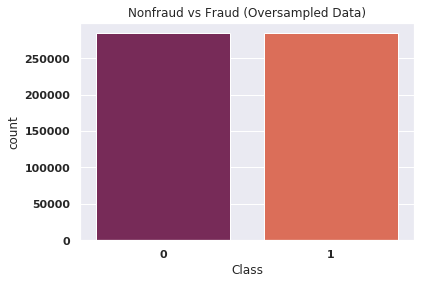

In [18]:
# Look at oversampled data
sns.set(style="darkgrid")
plt.title('Nonfraud vs Fraud (Oversampled Data)')
ax = sns.countplot(x="Class", data=up_df, palette='rocket')

up_df.Class.value_counts()

In [19]:
# Create a test set
X, y = up_df.drop('Class',1), up_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)


# Check it on an XGBClassifier
xg_cls = xgb.XGBClassifier(tree_method='gpu_exact')
xg_cls.fit(X_train,y_train)

preds = xg_cls.predict(X_test)

train_preds = xg_cls.predict(X_train)

In [20]:
# Accuracy tables on the training and test set

table_train = pd.crosstab(y_train, train_preds, margins=True)
table_test = pd.crosstab(y_test, preds, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    '***********************************\n'
    '********** Over Sampled ***********\n'
    '**************WRONG****************\n\n'    
    'Training set accuracy:\n'
    'Percent Type I errors:  {:.8f}\n'
    'Percent Type II errors: {:.8f}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {:.8f}\n'
    'Percent Type II errors: {:.8f}\n\n'
    '***********************************\n'
    '* Type I errors are normal purchases that have been flagged.\n'
    '* Type II errors are frauds that are not caught!\n'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

***********************************
********** Over Sampled ***********
**************WRONG****************

Training set accuracy:
Percent Type I errors:  0.00351503
Percent Type II errors: 0.00300063

Test set accuracy:
Percent Type I errors: 0.00353481
Percent Type II errors: 0.00312154

***********************************
* Type I errors are normal purchases that have been flagged.
* Type II errors are frauds that are not caught!



The improved error rate is because the program has seen that exact piece of data before! THIS IS OVERFITTING!

## Upsampling (The Correct Way)
#### Using SMOTE to create new fraud data!

In [21]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.619995,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660004,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798279,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.989998,0


In [22]:
# Split the training and test data first!
X, y = df.drop('Class',1), df['Class']

# Import SMOTE which is a upsampling function
from imblearn.over_sampling import SMOTE

# Create new fake fraud data
smote = SMOTE(random_state=11, ratio='minority')
X_sm, y_sm = smote.fit_sample(X, y)

# Split it for the test
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=11)

In [23]:

import xgboost as xgb

# Check it on an XGBClassifier
xg_cls = xgb.XGBClassifier(tree_method='gpu_exact')
xg_cls.fit(X_train, y_train)

preds = xg_cls.predict(X_test)

In [24]:
# Accuracy tables on the training and test set

table_test = pd.crosstab(y_test, preds, margins=True)

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    '***********************************\n'
    '********** Over Sampled ***********\n'
    '**************RIGHT****************\n\n'    
    'Test set accuracy:\n'
    'Percent Type I errors: {:.8f}\n'
    'Percent Type II errors: {:.8f}\n\n'
    '***********************************\n'
    '* Type I errors are normal purchases that have been flagged.\n'
    '* Type II errors are frauds that are not caught!\n'
).format(test_tI_errors, test_tII_errors))

***********************************
********** Over Sampled ***********
**************RIGHT****************

Test set accuracy:
Percent Type I errors: 0.00248844
Percent Type II errors: 0.01022633

***********************************
* Type I errors are normal purchases that have been flagged.
* Type II errors are frauds that are not caught!



In [25]:
# Make a new DataFrame with the training data (X and Y)
#Starts with putting it into an array
i = 0
arr = []
for elem in X_sm:
    arr.append(np.concatenate((elem, y_sm[i]), axis=None))
    i+=1

In [26]:
#Put it into a DataFrame
df1 = pd.DataFrame(columns=df.columns, data=arr)

1.0    284315
0.0    284315
Name: Class, dtype: int64

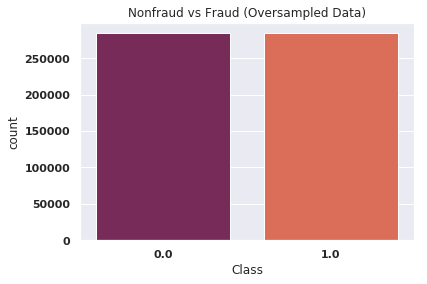

In [27]:
# Look at oversampled data
sns.set(style="darkgrid")
plt.title('Nonfraud vs Fraud (Oversampled Data)')
ax = sns.countplot(x="Class", data=df1, palette='rocket')

df1.Class.value_counts()

In [28]:
# Save it for future use
df1.to_pickle('../../Data/creditcardUP.pkl')

## Correlation Matrix / Feature Selection

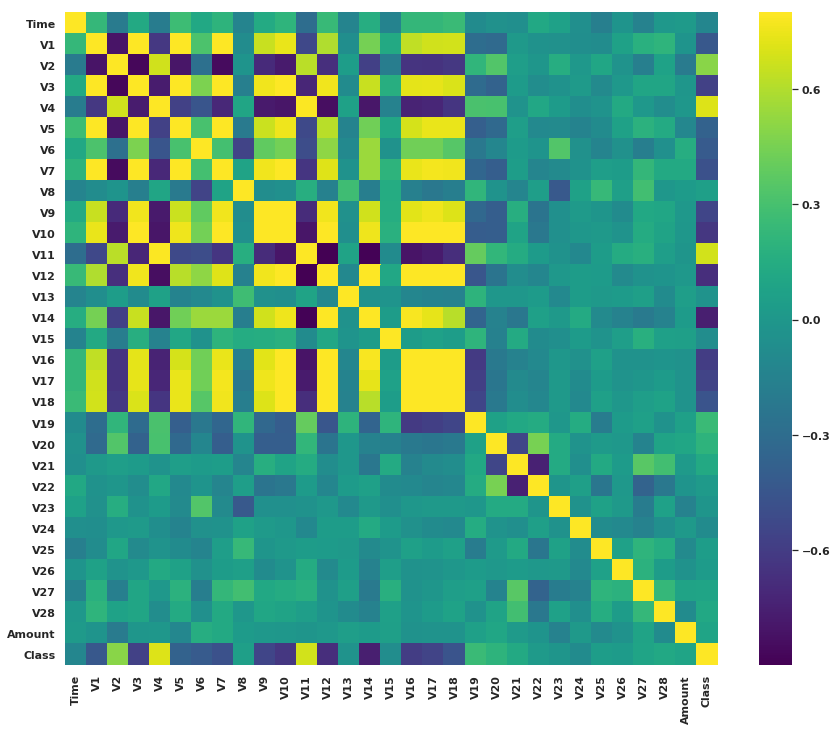

In [29]:
up_df = pd.read_pickle('../../Data/creditcardUP.pkl')
# Make the correlation matrix.
corrmat = up_df.corr()

f, ax = plt.subplots(figsize=(15, 12))

# Draw the heatmap
sns.heatmap(corrmat, vmax=.8, square=True, cmap='viridis')
plt.show()

In [30]:
# Create correlation matrix
corr_matrix = up_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [31]:
# Column to drop
to_drop

['V17']

In [32]:
# Drop features 
df1 = up_df.drop(to_drop, axis=1)

In [33]:
# Create a test set
X, y = df1.drop('Class',1), df1['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)


# Check it on an XGBClassifier
xg_cls = xgb.XGBClassifier(tree_method='gpu_exact')
xg_cls.fit(X_train,y_train)

preds = xg_cls.predict(X_test)

train_preds = xg_cls.predict(X_train)

In [34]:
# Accuracy tables on the training and test set

table_train = pd.crosstab(y_train, train_preds, margins=True)
table_test = pd.crosstab(y_test, preds, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    '***********************************\n'
    '********** Excluding V17 **********\n'
    '***********************************\n\n'    
    'Training set accuracy:\n'
    'Percent Type I errors:  {:.8f}\n'
    'Percent Type II errors: {:.8f}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {:.8f}\n'
    'Percent Type II errors: {:.8f}\n\n'
    '***********************************\n'
    '* Type I errors are normal purchases that have been flagged.\n'
    '* Type II errors are frauds that are not caught!\n'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

***********************************
********** Excluding V17 **********
***********************************

Training set accuracy:
Percent Type I errors:  0.00000000
Percent Type II errors: 0.00000000

Test set accuracy:
Percent Type I errors: 0.01522843
Percent Type II errors: 0.04060914

***********************************
* Type I errors are normal purchases that have been flagged.
* Type II errors are frauds that are not caught!



# Features Selection

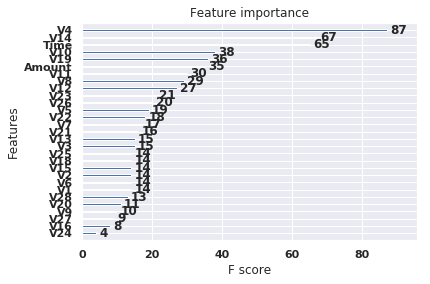

In [35]:
# Look at feature importance
xgb.plot_importance(xg_cls)
plt.rcParams['figure.figsize'] = [20, 3]
plt.show()

In [36]:
from sklearn import feature_selection
from sklearn.metrics import accuracy_score

listo = []

# Run the model with a different amount of features
# Start by the ones with most importance
thresholds = np.sort(xg_cls.feature_importances_)[::-1]
for thresh in thresholds:
    # select features using threshold
    selection = feature_selection.SelectFromModel(xg_cls, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    # train model
    selection_model = xgb.XGBClassifier(tree_method='gpu_exact')
    selection_model.fit(select_X_train, y_train)
    
    # eval model
    select_X_test = selection.transform(X_test)
    preds = selection_model.predict(select_X_test)
    
    table_test = pd.crosstab(y_test, preds, margins=True)
    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']
 
    accuracy = accuracy_score(y_test, preds)
    # Save to list so we can graph it
    listo.append([thresh, select_X_train.shape[1], test_tI_errors, test_tII_errors, accuracy*100.0])
    
    print("Thresh=%.3f, n=%d, Type I=%.8f, Type II=%.8f, Accuracy: %.4f%%" % (thresh, select_X_train.shape[1], test_tI_errors, test_tII_errors, accuracy*100.0))

Thresh=0.125, n=1, Type I=0.03045685, Type II=0.05076142, Accuracy: 91.8782%
Thresh=0.097, n=2, Type I=0.02030457, Type II=0.05076142, Accuracy: 92.8934%
Thresh=0.094, n=3, Type I=0.02538071, Type II=0.06091371, Accuracy: 91.3706%
Thresh=0.055, n=4, Type I=0.01015228, Type II=0.04568528, Accuracy: 94.4162%
Thresh=0.052, n=5, Type I=0.01522843, Type II=0.04568528, Accuracy: 93.9086%
Thresh=0.050, n=6, Type I=0.01522843, Type II=0.03553299, Accuracy: 94.9239%
Thresh=0.043, n=7, Type I=0.01015228, Type II=0.04060914, Accuracy: 94.9239%
Thresh=0.042, n=8, Type I=0.01015228, Type II=0.03045685, Accuracy: 95.9391%
Thresh=0.039, n=9, Type I=0.01522843, Type II=0.03045685, Accuracy: 95.4315%
Thresh=0.030, n=10, Type I=0.01522843, Type II=0.03045685, Accuracy: 95.4315%
Thresh=0.029, n=11, Type I=0.01015228, Type II=0.03045685, Accuracy: 95.9391%
Thresh=0.027, n=12, Type I=0.02030457, Type II=0.03553299, Accuracy: 94.4162%
Thresh=0.026, n=13, Type I=0.01522843, Type II=0.03553299, Accuracy: 94.9

In [37]:
dffeat = pd.DataFrame(listo, columns=['Thresh', 'N_Features', 'Type_I', 'Type_II', 'Accuracy'])

In [38]:
low_point = dffeat[dffeat['Type_II']==dffeat.Type_II.min()]

In [39]:
# Note, sometimes it jumps up by 2 features because they have the same importance
dffeat.head(10)

,Thresh,N_Features,Type_I,Type_II,Accuracy
0,0.125360,1,0.030457,0.050761,91.878173
1,0.096542,2,0.020305,0.050761,92.893401
2,0.093660,3,0.025381,0.060914,91.370558
3,0.054755,4,0.010152,0.045685,94.416244
4,0.051873,5,0.015228,0.045685,93.908629
5,0.050432,6,0.015228,0.035533,94.923858
6,0.043228,7,0.010152,0.040609,94.923858
7,0.041787,8,0.010152,0.030457,95.939086
8,0.038905,9,0.015228,0.030457,95.431472
9,0.030259,10,0.015228,0.030457,95.431472


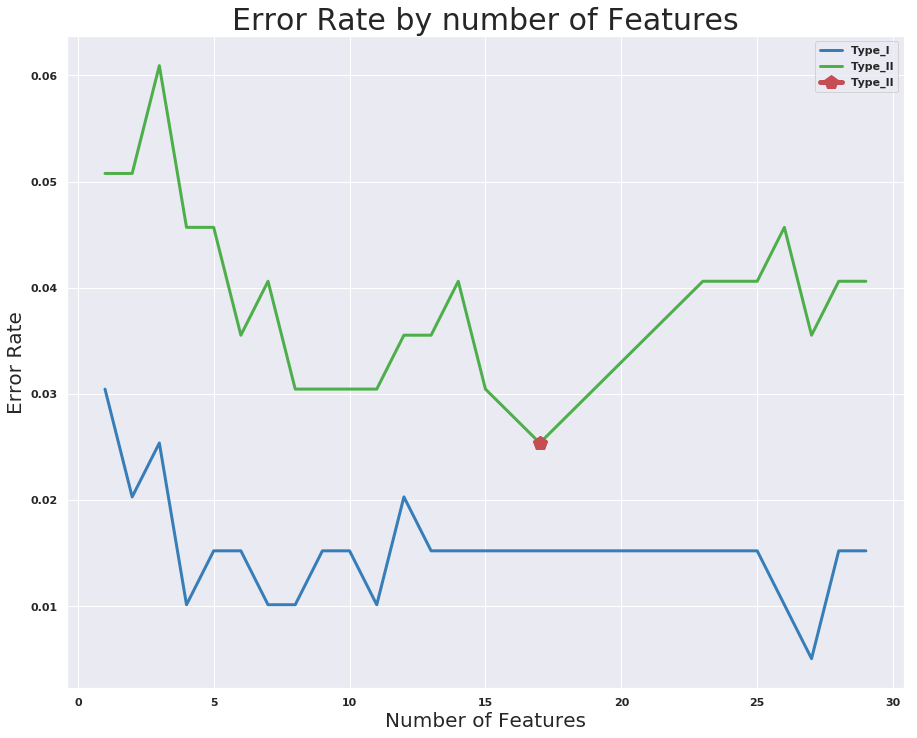

Low point for Type II 

    N_Features    Type_I   Type_II   Accuracy
15          17  0.015228  0.025381  95.939086
16          17  0.015228  0.025381  95.939086


In [40]:
palette = plt.get_cmap('Set1')
plt.subplots(figsize=(15, 12))
plt.title('Error Rate by Number of Features', fontsize=30)
plt.plot( 'N_Features', 'Type_I', data=dffeat, marker='',linewidth=3, color=palette(1))
plt.plot( 'N_Features', 'Type_II', data=dffeat, marker='', linewidth=3, color=palette(2))
plt.plot( 'N_Features', 'Type_II', data=low_point,MarkerSize=15, marker='p',linewidth=5, color='r')
plt.xlabel('Number of Features',fontsize=20, fontweight=0)
plt.ylabel('Error Rate',fontsize=20, fontweight=0)
plt.legend()
plt.show()

print('Low point for Type II \n\n' + str(low_point.drop('Thresh',1)))

In [41]:
# Find the cutoff point
if len(low_point.N_Features.values) >= 1:
    num = round(len(low_point.N_Features.values)/2)
else:
    num = 0

In [42]:
# Create a list of feature importance and their names
listoff=[]
for feature in zip(list(df1), xg_cls.feature_importances_):
    listoff.append(feature)
    print(feature)

('Time', 0.093659945)
('V1', 0.02017291)
('V2', 0.02017291)
('V3', 0.021613833)
('V4', 0.12536024)
('V5', 0.027377522)
('V6', 0.02017291)
('V7', 0.024495678)
('V8', 0.041786745)
('V9', 0.014409222)
('V10', 0.054755043)
('V11', 0.043227665)
('V12', 0.038904898)
('V13', 0.021613833)
('V14', 0.096541785)
('V15', 0.02017291)
('V16', 0.011527377)
('V18', 0.02017291)
('V19', 0.0518732)
('V20', 0.015850144)
('V21', 0.023054754)
('V22', 0.0259366)
('V23', 0.030259365)
('V24', 0.0057636886)
('V25', 0.02017291)
('V26', 0.028818443)
('V27', 0.0129683)
('V28', 0.018731989)
('Amount', 0.050432276)


In [43]:
# Sort the list and remove all but the top 19 features

listoff.sort(key=lambda tup: tup[1])
features_drop = []
for elem in listoff[:-int(low_point.N_Features.values[num])]:
    features_drop.append(elem[0])
    
# Append V17 which we dropped earlier
features_drop.append('V17')

In [44]:
features_drop

['V24',
 'V16',
 'V27',
 'V9',
 'V20',
 'V28',
 'V1',
 'V2',
 'V6',
 'V15',
 'V18',
 'V25',
 'V17']

In [45]:
# get up sampled df
dfold = pd.read_pickle(('../../Data/creditcardUNDER.pkl'))

In [46]:
# drop the features we don't want
dfnew = dfold.drop(features_drop,1)

In [47]:
# Save it so we have something to use in the future
dfnew.to_pickle(('../../Data/creditcardSELECTun.pkl'))

# Parameter Tuning

In [48]:
import pandas as pd
import numpy as np

# Open up the data with selected features
df = pd.read_pickle(('../../Data/creditcardSELECTun.pkl'))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 541 to 253086
Data columns (total 18 columns):
Time      984 non-null uint32
V3        984 non-null float32
V4        984 non-null float32
V5        984 non-null float32
V7        984 non-null float32
V8        984 non-null float32
V10       984 non-null float32
V11       984 non-null float32
V12       984 non-null float32
V13       984 non-null float32
V14       984 non-null float32
V19       984 non-null float32
V21       984 non-null float32
V22       984 non-null float32
V23       984 non-null float32
V26       984 non-null float32
Amount    984 non-null float32
Class     984 non-null uint8
dtypes: float32(16), uint32(1), uint8(1)
memory usage: 74.0 KB


In [49]:
from sklearn.model_selection import train_test_split
# Get training data
X, y = df.drop('Class',1), df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [50]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

max_depth = [3, 5, 10, 15, 20]
n_estimators = [10, 30, 50, 100, 150, 200, 250]
listy =[]

# Go through multiple depths and n_estimators to find best parameters

for max_d in max_depth:
    for n_est in n_estimators:
        
        # train model
        model = xgb.XGBClassifier(n_estimators=n_est, max_depth=max_d, tree_method='gpu_exact')
        model.fit(X_train, y_train)

        # eval model
        preds = model.predict(X_test)
        table_test = pd.crosstab(y_test, preds, margins=True)
        test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
        test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']
        accuracy = accuracy_score(y_test, preds)

        # Save to list so we can graph it
        listy.append([max_d, n_est, test_tI_errors, test_tII_errors, accuracy*100.0])
        print("max_depth=%.3f, n_estimators=%d, Type I=%.10f, Type II=%.10f, Accuracy: %.4f%%" % (max_d, n_est, test_tI_errors, test_tII_errors, accuracy*100.0))

max_depth=3.000, n_estimators=10, Type I=0.0101522843, Type II=0.0609137056, Accuracy: 92.8934%
max_depth=3.000, n_estimators=30, Type I=0.0152284264, Type II=0.0406091371, Accuracy: 94.4162%
max_depth=3.000, n_estimators=50, Type I=0.0203045685, Type II=0.0406091371, Accuracy: 93.9086%
max_depth=3.000, n_estimators=100, Type I=0.0152284264, Type II=0.0253807107, Accuracy: 95.9391%
max_depth=3.000, n_estimators=150, Type I=0.0152284264, Type II=0.0253807107, Accuracy: 95.9391%
max_depth=3.000, n_estimators=200, Type I=0.0152284264, Type II=0.0304568528, Accuracy: 95.4315%
max_depth=3.000, n_estimators=250, Type I=0.0152284264, Type II=0.0253807107, Accuracy: 95.9391%
max_depth=5.000, n_estimators=10, Type I=0.0152284264, Type II=0.0507614213, Accuracy: 93.4010%
max_depth=5.000, n_estimators=30, Type I=0.0152284264, Type II=0.0406091371, Accuracy: 94.4162%
max_depth=5.000, n_estimators=50, Type I=0.0152284264, Type II=0.0406091371, Accuracy: 94.4162%
max_depth=5.000, n_estimators=100, T

In [51]:
listy

[[3, 10, 0.01015228426395939, 0.06091370558375635, 92.89340101522842],
 [3, 30, 0.015228426395939087, 0.04060913705583756, 94.41624365482234],
 [3, 50, 0.02030456852791878, 0.04060913705583756, 93.90862944162437],
 [3, 100, 0.015228426395939087, 0.025380710659898477, 95.93908629441624],
 [3, 150, 0.015228426395939087, 0.025380710659898477, 95.93908629441624],
 [3, 200, 0.015228426395939087, 0.030456852791878174, 95.43147208121827],
 [3, 250, 0.015228426395939087, 0.025380710659898477, 95.93908629441624],
 [5, 10, 0.015228426395939087, 0.050761421319796954, 93.4010152284264],
 [5, 30, 0.015228426395939087, 0.04060913705583756, 94.41624365482234],
 [5, 50, 0.015228426395939087, 0.04060913705583756, 94.41624365482234],
 [5, 100, 0.015228426395939087, 0.04060913705583756, 94.41624365482234],
 [5, 150, 0.015228426395939087, 0.03553299492385787, 94.9238578680203],
 [5, 200, 0.015228426395939087, 0.03553299492385787, 94.9238578680203],
 [5, 250, 0.015228426395939087, 0.03553299492385787, 94.9

In [52]:
dfest = pd.DataFrame(listy, columns=['Max_Depth', 'N_Estimators', 'Type_I', 'Type_II', 'Accuracy'])

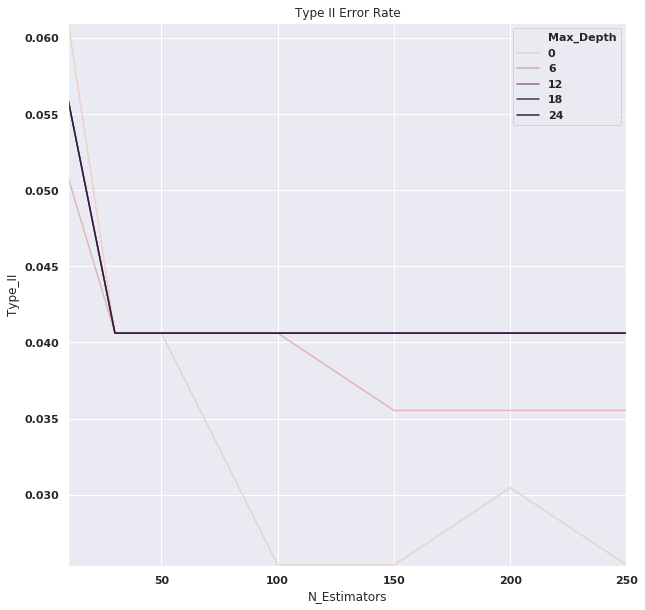

In [53]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.title('Type II Error Rate')
ax = sns.lineplot(x="N_Estimators", y="Type_II", hue='Max_Depth', data=dfest)
plt.legend()
ax.margins(x=0, y=.0025) 

In [54]:
# Put the low points into a dataframe
low_pointest = dfest[dfest['Type_II']==dfest.Type_II.min()]
int(low_pointest.head(1).Max_Depth)

3

In [55]:
# Open up the data with selected features
df = pd.read_pickle(('../../Data/creditcardSELECTun.pkl'))
X, y = df.drop('Class',1), df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

# We use the lowest max depth and N_est that gets the best value (lower = better runtime)
model = xgb.XGBClassifier(n_estimators=int(low_pointest.head(1).N_Estimators), max_depth=int(low_pointest.head(1).Max_Depth), tree_method='gpu_exact')
model.fit(X_train, y_train)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='gpu_exact')

In [56]:
dfold = pd.read_pickle(('../../Data/creditcard.pkl'))
dfold=dfold.drop(features_drop,1)

fX, fy = dfold.drop('Class',1), dfold['Class']

fulldatapreds = model.predict(dfold.drop('Class',1))
preds = model.predict(X_test)

In [57]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(model, X_test, y_test, cv=10))

[0.95238095 0.95238095 0.95238095 0.95       1.         0.94736842
 1.         0.94736842 0.94736842 0.68421053]


In [58]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(model, fX, fy, cv=10))

[0.97900428 0.99866582 0.99975422 0.99940311 0.99943822 0.99894663
 0.99961376 0.99957865 0.99947331 0.99929775]


In [59]:
# Accuracy tables on the training and test set

table_full = pd.crosstab(fy, fulldatapreds, margins=True)
table_test = pd.crosstab(y_test, preds, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    '***********************************\n\n'    
    'Full set accuracy:\n'
    'Percent Type I errors:  {:.15f}\n'
    'Percent Type II errors: {:.15f}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {:.15f}\n'
    'Percent Type II errors: {:.15f}\n\n'
    '***********************************\n'
    '* Type I errors are normal purchases that have been flagged.\n'
    '* Type II errors are frauds that are not caught!\n'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

***********************************

Full set accuracy:
Percent Type I errors:  0.000000000000000
Percent Type II errors: 0.000000000000000

Test set accuracy:
Percent Type I errors: 0.015228426395939
Percent Type II errors: 0.025380710659898

***********************************
* Type I errors are normal purchases that have been flagged.
* Type II errors are frauds that are not caught!



In [60]:
table_test

col_0,0,1,All
Class,,,
0,90,3,93
1,5,99,104
All,95,102,197


In [61]:
table_full

col_0,0,1,All
Class,,,
0,274974,9341,284315
1,6,486,492
All,274980,9827,284807


In [62]:
probs = model.predict_proba(fX)[:,1]

In [63]:
probs

array([0.05666421, 0.03355011, 0.06916515, ..., 0.00386842, 0.01995605,
       0.02789387], dtype=float32)

In [64]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(fy, probs)


auc = roc_auc_score(fy, probs)
print('AUC: %.20f' % auc)

AUC: 0.99696487020794100076


In [65]:
from sklearn.metrics import recall_score

recall_score(fy, fulldatapreds)

0.9878048780487805

In [66]:
recall_score(y_test, preds)

0.9519230769230769